In [1]:
:e DataKinds
:e TypeOperators
:e TypeApplications
:e ScopedTypeVariables
:e FlexibleContexts
:e ViewPatterns
:e KindSignatures
:e TypeFamilies
:e RankNTypes

:s -fplugin GHC.TypeLits.KnownNat.Solver
:s -fplugin GHC.TypeLits.Normalise

import           GHC.TypeLits
import           Numeric.LinearAlgebra.Static
import qualified Numeric.LinearAlgebra as LA
import           Data.Proxy
import qualified Numeric.LinearProgramming.L1 as L1
import Data.Maybe
import System.Random
import qualified Data.Vector.Storable as V
import Data.Proxy
import Data.Tuple.HT (fst3)

-- For plotting
import Graphics.Rendering.Chart
import Data.Colour
import Data.Colour.Names
import Data.Default.Class
import Graphics.Rendering.Chart.Backend.Cairo
import Control.Lens


In [2]:
data Coord (n :: Nat) = Coord

atV :: forall n k . (KnownNat n, KnownNat k, k+1<=n) => R n -> Coord k -> Double
atV v _ = extract v LA.! pos
  where
    pos = fromIntegral . natVal $ (undefined :: Proxy k)

atM :: forall m n i j . (KnownNat m, KnownNat n, KnownNat i, KnownNat j, i+1<=m, j+1 <=n)
   => L m n -> Coord i -> Coord j -> Double
atM m _ _ = extract m `LA.atIndex` (pi,pj)
  where
    pi = fromIntegral . natVal $ (undefined :: Proxy i)
    pj = fromIntegral . natVal $ (undefined :: Proxy j)

foldR :: KnownNat n => (b -> Double -> b) -> b -> R n -> b
foldR f initial x = V.foldl' f initial (extract x)

foldR1 :: KnownNat n => (Double -> Double -> Double) -> R n -> Double
foldR1 f x = V.foldl1' f (extract x)

In [3]:
lsq_lipschitz :: (KnownNat m, KnownNat n) => L m n -> Double
lsq_lipschitz a = foldR1 max . eigenvalues $ mTm a

quadratic_lipschitz :: (KnownNat n) => Sym n -> Double
quadratic_lipschitz = foldR1 max . eigenvalues 

In [4]:
indicator_box :: Double -> Double -> (forall n. KnownNat n => R n -> Double)
indicator_box l u = foldR (\a b -> a + (if (b > u) || (b < l) then 1/0 else 0)) 0

In [5]:
prox_indicator_box :: Double -> Double -> (forall n. KnownNat n => R n -> R n)
prox_indicator_box l u = dvmap bound
    where
        bound x = case (x < l, x > u) of
                      (True, _) -> l
                      (_, True) -> u
                      _         -> x

In [20]:
-- | Fast Iterative Soft Thresholding Algorithm
-- Used to solve problems of the form F(x) = f(x) + g(x), where
-- f is a smooth convex function with grad F being L-Lipschitz continuous and 
-- g is a (potentially non-smooth) convex function. Common problems solved
-- with FISTA include min ||Ax - b|| st. x \in C or min ||Ax - b|| + ||x||_1
fista :: (KnownNat n) =>
        (R n -> R n)    -- ^ gradient of f
     -> (R n -> R n)    -- ^ proximal operator of g
     -> Double          -- ^ Lipschitz constant
     -> Maybe (R n)     -- ^ Initial guess at a solution
     -> [R n]           -- ^ Output cost function and optimal solution over time
fista grad_f prox_g lipschitz (maybe (konst 0) id -> x0) = map fst3 $ iterate go (x0, x0, 1)
    where
        -- Sometimes update is called p_L
        gradient_step = \x -> x - (konst (1/lipschitz)) * grad_f x
        prox_step = \x -> prox_g x
        update = prox_step . gradient_step
        
        -- Algorithm here 
        go (x, y, t) = let
            x_update = update y
            t_update = (1 + sqrt (1 + 4*t^^2))/2
            y_update = x_update + (konst $ (t - 1)/(t_update)) * (x_update - x)
            in (x_update, y_update, t_update)

fista_cost :: KnownNat n => (R n -> Double) -> (R n -> Double) -> R n -> Double
fista_cost f g x = f x + g x 

In [21]:
residuals :: forall n. KnownNat n => [R n] -> [Double]
residuals x = zipWith (\x xn -> norm_2 (x - xn)) x (tail x)

In [22]:
a <- randn :: IO (L 200 200)
l = lsq_lipschitz a
signal = dvmap (\x -> sin x ^ 2) $ linspace (0, 12):: R 200
b = a #> signal

In [23]:
f = (\x -> norm_2 (a #> x - b))
g = (const 0)
grad_f = (\x -> tr a #> (a #> x - b))
prox_g = id

cost = fista_cost f (indicator_box 0 1)

In [24]:
l1_cost :: (KnownNat n) => Double -> R n -> Double
l1_cost lambda = (lambda*) . norm_1

l1_prox :: (KnownNat n) => Double -> R n -> R n
l1_prox lambda = dvmap f
    where
        f xi = signum xi * max (abs xi - lambda) 0

In [25]:
sols = fista grad_f prox_g l Nothing
sols_box = fista grad_f (prox_indicator_box 0 1) l Nothing

In [26]:
iterations = 200
sol = last $ take iterations sols
sol_box = last $ take iterations sols_box

Line 1: Use camelCase
Found:
fista_sol_chart = ...
Why not:
fistaSolChart = ...

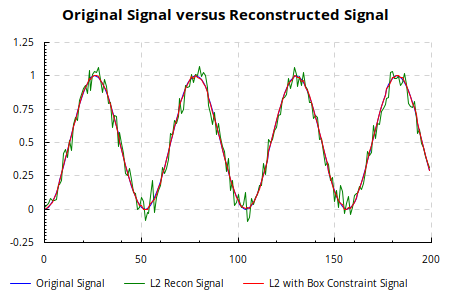

In [27]:
fista_sol_chart = toRenderable layout
  where
    original = plot_lines_values .~ [zip [0..] (V.toList $ extract signal)]
              $ plot_lines_style  . line_color .~ opaque blue
              $ plot_lines_title .~ "Original Signal"
              $ def
              
    recon = plot_lines_values .~ [zip [0..] (V.toList $ extract sol)]
              $ plot_lines_style  . line_color .~ opaque green
              $ plot_lines_title .~ "L2 Recon Signal"
              $ def
              
    recon_box = plot_lines_values .~ [zip [0..] (V.toList $ extract sol_box)]
              $ plot_lines_style  . line_color .~ opaque red
              $ plot_lines_title .~ "L2 with Box Constraint Signal"
              $ def
              
    layout = layout_title .~ "Original Signal versus Reconstructed Signal"
           $ layout_plots .~ [toPlot original,
                              toPlot recon,
                              toPlot recon_box]
           $ def
fista_sol_chart

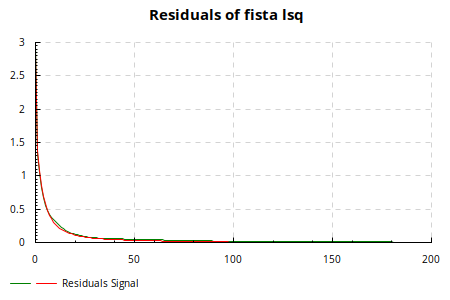

In [28]:
res = take iterations $ residuals sols
res_box = take iterations $ residuals sols_box

fista_residuals_chart = toRenderable layout
  where
    residuals = plot_lines_values .~ [zip [0..] res]
              $ plot_lines_style  . line_color .~ opaque green
              $ plot_lines_title .~ "Residuals Signal"
              $ def
    residuals_box = plot_lines_values .~ [zip [0..] res_box]
              $ plot_lines_style  . line_color .~ opaque red
              $ plot_lines_title .~ "Residuals Signal"
              $ def
              
    layout = layout_title .~ "Residuals of fista lsq"
           $ layout_plots .~ [toPlot residuals,
                              toPlot residuals_box]
           $ def
fista_residuals_chart

In [29]:
m = 200
n = 1000
s = 30 -- Sparsity, number of non-zero elements in the signal

-- Random state transition matrix
a = LA.reshape n $ LA.randomVector 0 LA.Gaussian (n*m)

-- Create a signal with `s` elements being either -1 or 1.
g = mkStdGen 0
indx = take s $ randomRs (0, n - 1) g :: [Int]
r = take s $ fmap ([1, 1] !!) $ randomRs (0, 1) g
signal = V.replicate n 0 V.// zip indx r
b = a LA.#> signal

-- Make dependently typed versions of the signal.
a_static = fromJust $ create a :: L 200 1000
signal_static = fromJust $ create signal :: R 1000
b_static = a_static #> signal_static

l = lsq_lipschitz a_static

In [32]:
lambda = 0.0005
f_l1 = (\x -> norm_2 (a_static #> x - b_static))
grad_f_l1 = (\x -> (tr a_static #> (a_static #> x - b_static)))

l1_sols = fista grad_f_l1 (l1_prox lambda) l Nothing
l2_sols = fista grad_f_l1 id l Nothing 

In [33]:
iterations = 300
l1_sol = last $ take iterations l1_sols
l2_sol = last $ take iterations l2_sols

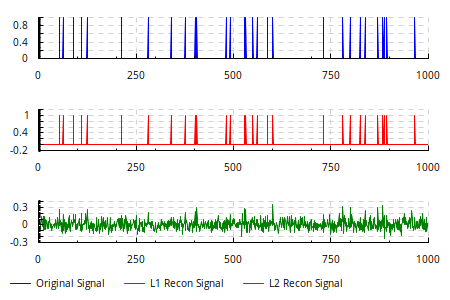

In [34]:
fista_l1_sol_chart f = f layout1 layout2 layout3
  where
    original = plot_lines_values .~ [zip [0..] (V.toList $ extract signal_static)]
              $ plot_lines_style  . line_color .~ opaque blue
              $ plot_lines_title .~ "Original Signal"
              $ def
              
    recon_l1 = plot_lines_values .~ [zip [0..] (V.toList $ extract l1_sol)]
              $ plot_lines_style  . line_color .~ opaque red
              $ plot_lines_title .~ "L1 Recon Signal"
              $ def
              
    recon_l2 = plot_lines_values .~ [zip [0..] (V.toList $ extract l2_sol)]
              $ plot_lines_style  . line_color .~ opaque green
              $ plot_lines_title .~ "L2 Recon Signal"
              $ def
              
    layout1 = layout_plots .~ [toPlot original]
            $ def
            
    layout2 = layout_plots .~ [toPlot recon_l1]
            $ def
            
    layout3 = layout_plots .~ [toPlot recon_l2]
            $ def
            
mkStack ls f = 
  renderStackedLayouts 
  $ slayouts_layouts .~ ls
  $ slayouts_compress_legend .~ f
  $ def
            
l1_plot = fista_l1_sol_chart f
    where
        f l1 l2 l3 = mkStack [StackedLayout l1, StackedLayout l2, StackedLayout l3] True
        
toRenderable l1_plot

In [35]:
-- renderableToFile (FileOptions (800, 500) PDF) "../main/fig/l1.pdf" $ fillBackground def $ toRenderable l1_plot